In [104]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

pi = np.pi
exp = np.exp
sqrt = np.sqrt

In [105]:
Nq = 2  # number of levels in qubit
N1 = 3  # number of levels in resonator 1
N2 = 3  # number of levels in resonator 2

wq = 7e9*2*pi  # qubit frequency
w1 = wq        # resonator 1 frequency
w2 = wq        # resonator 2 frequency
wp = wq        # pump frequency

kq = 50e3*2*pi
k1 = 5e3*2*pi
k2 = 6e6*2*pi

g1 = 1e6*2*pi  # drive frequency resonator 1
g2 = 5e6*2*pi  # drive frequency resonator 2
Omega = 1e6*2*pi  # pump frequency

Ec = 200e6*2*pi  # Anharmonicity

t0 = 0            # start Gaussian pulse Omega
t1 = t0 + 50e-9   # end Gaussian pulse Omega
t2 = t1 + 10e-9   # start square pulse at resonator 1
t3 = t2 + 300e-9  # end square pulse at resonator 1
t4 = t3 + 10e-9   # start square pulse at resonator 2
t5 = t4 + 300e-9  # end square pulse at resonator 2
t6 = t5 + 10e-9   # t0
tg = 10e-9        # Gaussian rise and fall time of square pulse

N_repeat = 2  # number of times to repeat cycle

In [106]:
# Transmon operators
b = tensor(destroy(Nq), qeye(N1), qeye(N2))
n = b.dag()*b

# Cavity operators
a1 = tensor(qeye(Nq), destroy(N1), qeye(N2))
a2 = tensor(qeye(Nq), qeye(N1), destroy(N2))

# Jaynes-Cummings Hamiltonian
Hjc = ( (w1*a1.dag()*a1) 
      + (w2*a2.dag()*a2) 
      + (wq*b.dag()*b) 
      + Ec/2*b.dag()*b.dag()*b*b )

# Coupling Hamiltonians
H1 = g1*(a1*b.dag() + b*a1.dag())
H2 = g2*(a1*b.dag() + b*a2.dag())

# Pump Hamiltonian
Hp = Omega/2*(b + b.dag)  # TODO: add rotating frame

# Hamiltonian arguments
H_args = {"t0" : t0, "t1" : t1, "t2" : t2, "t3" : t3, 
          "t4" : t4, "t5" : t5, "t6" : t6, "tg" : tg,
          "g1" : g1, "g2" : g2, "Omega" : Omega}

In [107]:
def gauss(t, args):
    t0 = args['t0']  # start of pulse
    t1 = args['t1']  # end of pulse
    Omega = args['Omega']  # pulse strength
    
    mu = (t1-t0)/2  # pulse center in time domain
    Q = 3  # number of std's in pulse, measure for step at t0 and t1
    std = (t1-t0)/(2*Q)  # standard deviation
    confine = np.heaviside((t-t0), 0) - np.heaviside((t-t1), 0)  # entire pulse
    
    pulse = Omega/(2*pi*std**2)*exp(-(t-mu)**2/(2*std**2))*confine
    return pulse


def square1(t, args):
    t2 = args['t2']  # start of pulse
    t3 = args['t3']  # end of pulse
    tg = args['tg']  # time of Gaussian rise and fall
    g1 = args['g1']  # pulse strength
    
    confine = np.heaviside((t-t2), 0) - np.heaviside((t-t3), 0)  # entire pulse
    
    # Rise and fall with Gaussian
    mu = t2+tg  # center of Gaussian
    Q = 3  # number of std's in Gaussian
    std = tg/Q  # standard deviation of Gaussian
    gauss = lambda mu : 1/sqrt(2*pi*std**2)*exp(-(t-mu)**2/(2*std**2))  # Gaussian
    top = lambda std : 1/sqrt(2*pi*std**2)  # height of the Gaussian
    scale = g1/top(std)  # scale factor to attach Gaussian to block
    
    
    block = g1*(np.heaviside((t-(t2+tg)), 0) - np.heaviside((t-(t3-tg)), 0))
    rise = scale*gauss(t2+tg) * (1-np.heaviside((t-(t2+tg)), 0))
    fall = scale*gauss(t3-tg) * (np.heaviside((t-(t3-tg)), 0))
    
    pulse = (rise + block + fall)*confine
    return pulse


def square2(t, args):
    t4 = args['t4']  # start of pulse
    t5 = args['t5']  # end of pulse
    tg = args['tg']  # time of Gaussian rise and fall
    g2 = args['g2']  # pulse strength
    
    confine = np.heaviside((t-t4), 0) - np.heaviside((t-t5), 0)  # entire pulse
    
    # Rise and fall with Gaussian
    mu = t4+tg  # center of Gaussian
    Q = 3  # number of std's in Gaussian
    std = tg/Q  # standard deviation of Gaussian
    gauss = lambda mu : 1/sqrt(2*pi*std**2)*exp(-(t-mu)**2/(2*std**2))  # Gaussian
    top = lambda std : 1/sqrt(2*pi*std**2)  # height of the Gaussian
    scale = g2/top(std)  # scale factor to attach Gaussian to block
    
    
    block = g2*(np.heaviside((t-(t4+tg)), 0) - np.heaviside((t-(t5-tg)), 0))
    rise = scale*gauss(t4+tg) * (1-np.heaviside((t-(t4+tg)), 0))
    fall = scale*gauss(t5-tg) * (np.heaviside((t-(t5-tg)), 0))
    
    pulse = (rise + block + fall)*confine
    return pulse

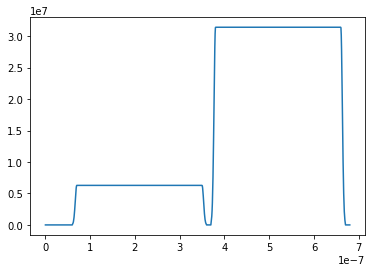

In [108]:
import matplotlib.pyplot as plt
t = np.linspace(0, t6, 1000)
pulse = square1(t, H_args) + square2(t, H_args)
plt.plot(t, pulse)